In [2]:
# Dataframe
import pandas as pd

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#Regular Expressions
import re

# Maptplolib
import matplotlib.pyplot as plt 

#Numpy
import numpy as np 

# Seaborn
import seaborn as sns 

# Scikit-learn
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## **Read Data**

In [3]:
drugs_df = pd.read_csv('train.csv')
drugs_df.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


## **Drop unwanted columns**

In [4]:
drugs_df.drop(['unique_hash','drug'],axis=1,inplace=True)
drugs_df.head()

,text,sentiment
0,Autoimmune diseases tend to come in clusters. ...,2
1,I can completely understand why you’d want to ...,2
2,Interesting that it only targets S1P-1/5 recep...,2
3,"Very interesting, grand merci. Now I wonder wh...",2
4,"Hi everybody, My latest MRI results for Brain ...",1


In [5]:
drugs_df.shape

(5279, 2)

### sentiment: {
### 1:negative,
### 2:positive,
### 0:neutral
### }

## **Data Visualization**

### Distribution of Target Column

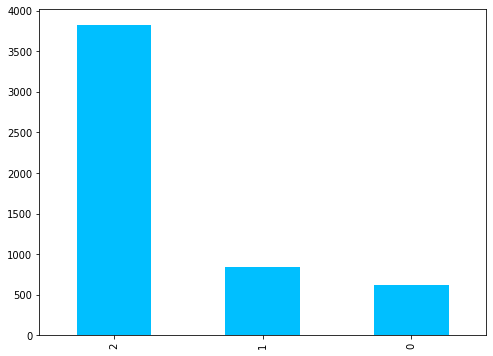

In [6]:
plt.figure(figsize=(8,6))
label=['positive','negative','neutral']
drugs_df.sentiment.value_counts().plot(kind='bar',color='deepskyblue');

## **Text Preprocessing**

In [7]:
corpous = list()
ps = PorterStemmer()
for i in range(len(drugs_df)):
    sent = re.sub(r'[^a-zA-Z]',' ',drugs_df.text[i])
    sent = sent.lower()
    sent = sent.split()
    sent = [ps.stem(word) for word in sent if word not in set(stopwords.words('english'))]
    sent = ' '.join(sent)
    corpous.append(sent)

## **Data Transformation**

### We used CountVectorizer to transform a given text into a vector on the basis of the frequency of each word that occurs in the entire text.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=3000,ngram_range=(1,3))
X = cv.fit_transform(corpous).toarray()

In [9]:
y = drugs_df.sentiment

## **Split Data for training and validation**

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=43)

## **Handle Imbalnce Data**

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
new_X_train, new_y_train = oversample.fit_resample(X_train, y_train)

In [12]:
print(X_train.shape)

(3695, 3000)


In [13]:
print(new_X_train.shape)

(7947, 3000)


In [14]:
y_test.value_counts()

2    1176
1     234
0     174
Name: sentiment, dtype: int64

In [15]:
new_y_train.value_counts()

2    2649
1    2649
0    2649
Name: sentiment, dtype: int64

## **Model Building**

### **1]Dicision Tree**

In [16]:
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier()
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(new_X_train, new_y_train)

In [17]:
# grid_search.best_params_

In [28]:
new_dt = DecisionTreeClassifier(max_depth=20, min_samples_leaf=5,criterion='gini')
new_dt.fit(new_X_train,new_y_train)
new_dt.score(X_test,y_test)

0.5366161616161617

### **Classification Report**

In [31]:
y_pred1 = new_dt.predict(X_test)
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.16      0.39      0.23       174
           1       0.24      0.26      0.25       234
           2       0.78      0.61      0.69      1176

    accuracy                           0.54      1584
   macro avg       0.40      0.42      0.39      1584
weighted avg       0.64      0.54      0.57      1584



### **Confusion Matrix**

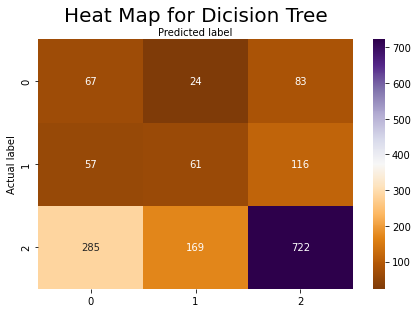

In [32]:
class_names = [0, 1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
cnf_matrix = confusion_matrix(y_test, y_pred1)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='PuOr',
            fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Heat Map for Dicision Tree', {'fontsize': 20})
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


### **2] Random Forest**

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [22]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(new_X_train, new_y_train)

In [23]:
rf_random.best_estimator_

In [29]:
new_rf = RandomForestClassifier(n_estimators=600,bootstrap=False,max_depth=60, min_samples_leaf=2)
new_rf.fit(new_X_train,new_y_train)
print("%.2f"%abs(new_rf.score(X_test,y_test)*100))

68.43


### **Classification Report For Random Forest**

In [34]:
y_pred2 = new_rf.predict(X_test)
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.23      0.16      0.18       174
           1       0.32      0.18      0.23       234
           2       0.76      0.86      0.81      1176

    accuracy                           0.68      1584
   macro avg       0.44      0.40      0.41      1584
weighted avg       0.64      0.68      0.65      1584



### **Confusion Matrix**

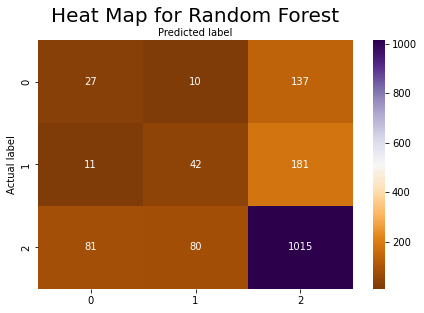

In [35]:
class_names = [0, 1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
cnf_matrix = confusion_matrix(y_test, y_pred2)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='PuOr',
            fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Heat Map for Random Forest', {'fontsize': 20})
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()